# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [23]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
%matplotlib inline
import heapq
from itertools import permutations

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


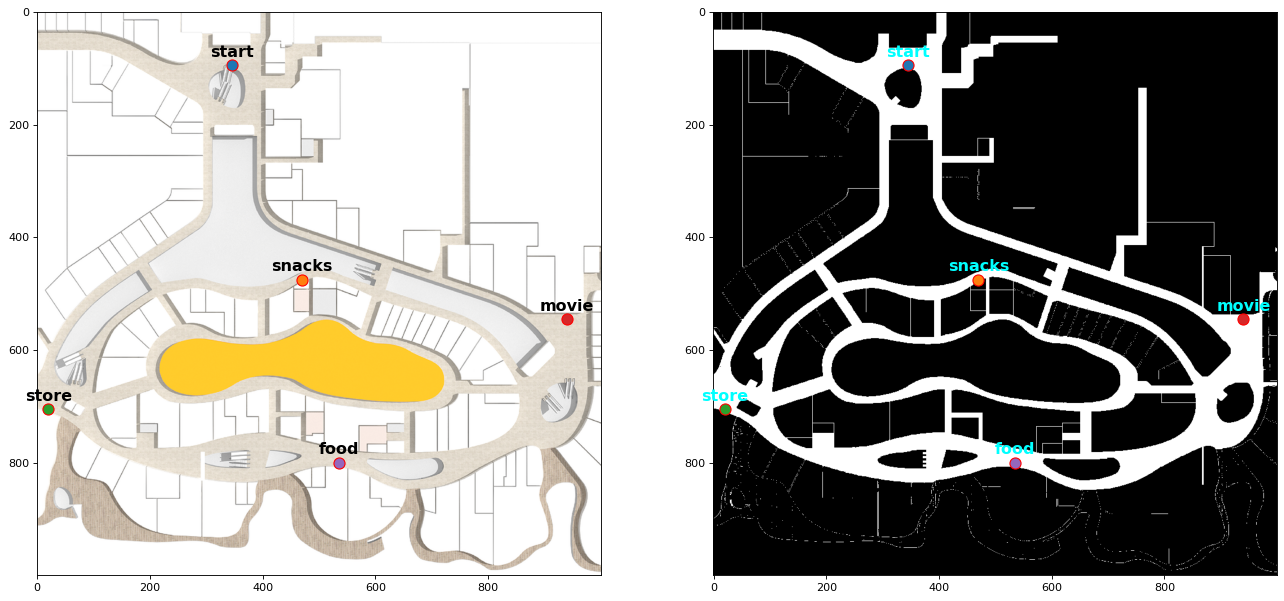

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [24]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [25]:
def heuristic(a, b, method='diagonal'):
    """
    Heuristic function for A* algorithm.

    Parameters:
    - a, b: Tuple (x, y) coordinates of two points.
    - method: Heuristic method, choose from 'manhattan', 'euclidean', 'diagonal', or 'chebyshev'.

    Returns:
    - Estimated cost from point 'a' to point 'b'.
    """

    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])

    if method == 'manhattan':
        return dx + dy  # Manhattan distance
    elif method == 'euclidean':
        return np.sqrt(dx ** 2 + dy ** 2)  # Euclidean distance
    elif method == 'diagonal':
        D = 0.2  # Cost for horizontal or vertical movement
        D2 = 0.282  # Cost for diagonal movement
        return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)  # Diagonal distance approximation
    elif method == 'chebyshev':
        return max(dx, dy)  # Chebyshev distance
    else:
        raise ValueError("Unknown heuristic method: choose from 'manhattan', 'euclidean', 'diagonal', or 'chebyshev'")

def astar(grid, start, goal):
    """
    A* pathfinding algorithm using 8-directional movement.

    Parameters:
    - grid: 2D numpy array representing the map (0 = obstacle, 255 = free space).
    - start: Tuple (x, y) representing the start position.
    - goal: Tuple (x, y) representing the goal position.

    Returns:
    - path: List of tuples representing the optimal path from start to goal.
    - distance: The actual physical distance of the path.
    """

    rows, cols = grid.shape
    neighbors = [  # 8-directional movement
        (0, 1, 0.2), (1, 0, 0.2), (0, -1, 0.2), (-1, 0, 0.2),  # Up, Down, Left, Right
        (1, 1, 0.282), (-1, -1, 0.282), (1, -1, 0.282), (-1, 1, 0.282)  # Diagonal movements
    ]

    open_set = []
    heapq.heappush(open_set, (0, 0, start, None))  # (f_score, g_score, position, parent)

    came_from = {}  # Dictionary to track the path
    g_score = {start: 0}  # Cost from start to each node
    f_score = {start: heuristic(start, goal)}  # Estimated total cost

    while open_set:
        _, g, current, parent = heapq.heappop(open_set)

        if current in came_from:
            continue
        came_from[current] = parent  # Track the path

        if current == goal:
            path = []
            while current:
                path.append(current)
                current = came_from[current]
            return path[::-1], g  # Return the path and actual travel distance

        for dx, dy, cost in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)

            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if grid[neighbor] == 0:  # Avoid obstacles
                    continue

                new_g = g + cost  # Accumulate path cost

                if neighbor not in g_score or new_g < g_score[neighbor]:
                    g_score[neighbor] = new_g
                    f_score[neighbor] = new_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], new_g, neighbor, current))

    return None, float('inf')  # No valid path found


In [26]:
# Key locations names
waypoints = ['start', 'snacks', 'store', 'movie', 'food']

# Store paths and distances
path_dict = {}
distance_dict = {}

# Generate all possible pairs of locations (without repetition)
for loc1, loc2 in permutations(waypoints, 2):
    path, dist = astar(grid_map, tuple(locations[loc1]), tuple(locations[loc2]))
    path_dict[(loc1, loc2)] = path  # Store the path between loc1 and loc2
    distance_dict[(loc1, loc2)] = dist  # Store the distance between loc1 and loc2
    print(f"{loc1} → {loc2}: {dist:.2f} m")  # Output the distance between loc1 and loc2


start → snacks: 140.88 m
start → store: 154.20 m
start → movie: 178.20 m
start → food: 218.64 m
snacks → start: 140.88 m
snacks → store: 114.17 m
snacks → movie: 106.42 m
snacks → food: 129.53 m
store → start: 154.20 m
store → snacks: 114.17 m
store → movie: 208.35 m
store → food: 110.79 m
movie → start: 178.20 m
movie → snacks: 106.42 m
movie → store: 208.35 m
movie → food: 111.23 m
food → start: 218.64 m
food → snacks: 129.53 m
food → store: 110.79 m
food → movie: 111.23 m


In [27]:
def total_distance(route):
    """Calculate the total distance of the given route"""
    return sum(distance_dict[(route[i], route[i+1])] for i in range(len(route)-1))

# Calculate all possible visiting orders
best_route = None
min_distance = float('inf')

for perm in permutations(waypoints[1:]):  # Permute snacks, store, movie, food
    route = ('start',) + perm + ('start',)  # Fix start point
    dist = total_distance(route)
    if dist < min_distance:
        min_distance = dist
        best_route = route

print(f"Optimal route: {' → '.join(best_route)}")
print(f"Shortest distance: {min_distance:.2f} m")


Optimal route: start → store → food → movie → snacks → start
Shortest distance: 623.52 m


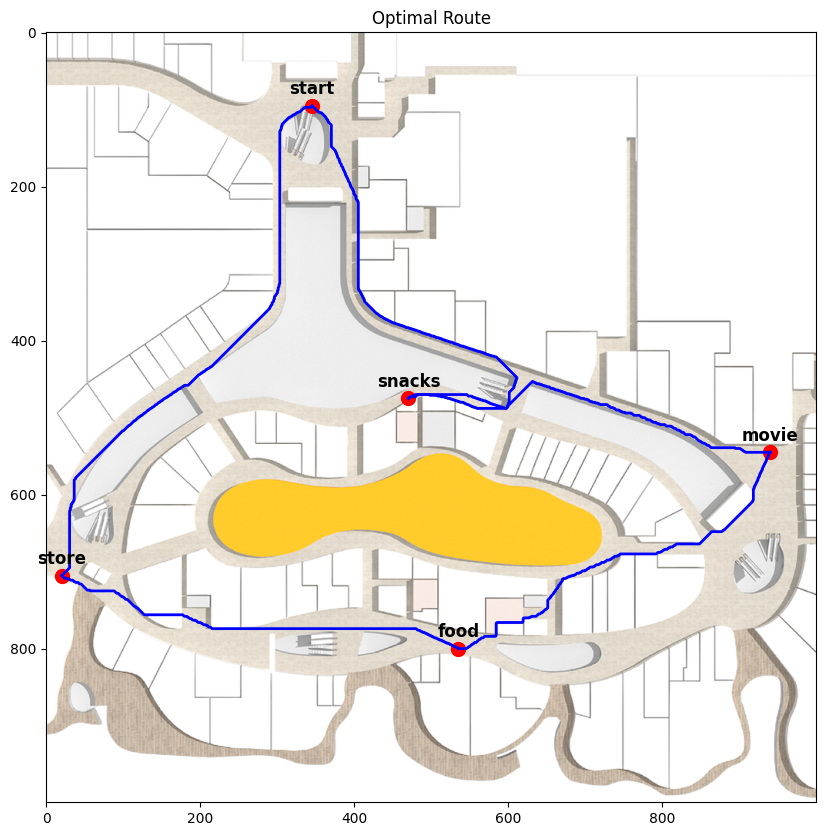

In [28]:
def plot_path_on_map(floor_plan, paths, route, locations):
    """Draw the path on the map"""
    plt.figure(figsize=(10, 10), dpi=100)
    plt.imshow(floor_plan)

    # Draw key locations
    for key, value in locations.items():
        plt.scatter(value[0], value[1], color='red', s=100)
        plt.text(value[0], value[1] - 15, key, fontsize=12, fontweight='bold', color='black', ha='center')

    # Draw the path
    for i in range(len(route)-1):
        start, end = route[i], route[i+1]
        path = paths[(start, end)]
        if path:
            path = np.array(path)
            plt.plot(path[:, 0], path[:, 1], linestyle='-', linewidth=2, color='blue')

    plt.title("Optimal Route")
    plt.show()

# Draw the optimal path
plot_path_on_map(floor_plan, path_dict, best_route, locations)


## Task 2

In [38]:
# Define locations and distance table (computed from Task 1)
distance_table = {
    ('start', 'snacks'): 140.88, ('snacks', 'start'): 140.88,
    ('start', 'store'): 154.20, ('store', 'start'): 154.20,
    ('start', 'movie'): 178.20, ('movie', 'start'): 178.20,
    ('start', 'food'): 218.64, ('food', 'start'): 218.64,

    ('snacks', 'store'): 114.17, ('store', 'snacks'): 114.17,
    ('snacks', 'movie'): 106.42, ('movie', 'snacks'): 106.42,
    ('snacks', 'food'): 129.53, ('food', 'snacks'): 129.53,

    ('store', 'movie'): 208.35, ('movie', 'store'): 208.35,
    ('store', 'food'): 110.79, ('food', 'store'): 110.79,
    
    ('movie', 'food'): 111.23, ('food', 'movie'): 111.23,
}


### Brute Force Method Implementation

In [39]:
# Function to compute total distance for a given route
def total_distance(route):
    dist = 0
    for i in range(len(route)-1):
        dist += distance_table[(route[i], route[i+1])]  # Add distance between consecutive locations
    dist += distance_table[(route[-1], route[0])]  # Return to start
    return dist

# Generate all possible routes and compute total distance
shortest_distance = float('inf')
shortest_route = None

for route in permutations(locations):
    dist = total_distance(route)
    if dist < shortest_distance:
        shortest_distance = dist
        shortest_route = route

shortest_route = shortest_route + ('start',)  # Concatenate 'start' at the end

print("Optimal route:", shortest_route)
print(f"Total distance: {shortest_distance:.2f} m")


Optimal route: ('start', 'snacks', 'movie', 'food', 'store', 'start')
Total distance: 623.52 m


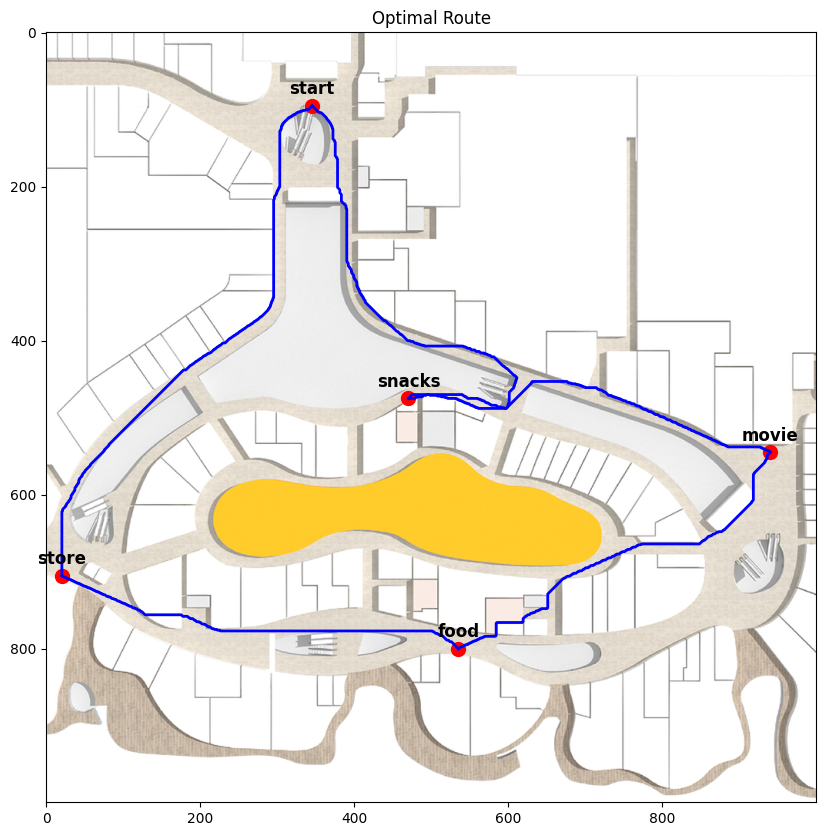

In [40]:
plot_path_on_map(floor_plan, path_dict, shortest_route, locations)

### Greedy Method Implementation

In [41]:
def greedy_tsp(start, locations, distance_table):
    route = [start]
    current_location = start
    total_dist = 0
    while len(route) < len(locations):
        # Find the nearest unvisited location
        nearest = min([loc for loc in locations if loc not in route], 
                      key=lambda loc: distance_table[(current_location, loc)])
        route.append(nearest)
        total_dist += distance_table[(current_location, nearest)]
        current_location = nearest
    route.append(start)
    total_dist += distance_table[(current_location, start)]  # Return to start
    return route, total_dist

# Apply greedy approach
start = 'start'
greedy_route, greedy_distance = greedy_tsp(start, locations, distance_table)

print("Greedy route:", greedy_route)
print(f"Total distance: {greedy_distance:.2f} m")


Greedy route: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total distance: 623.52 m


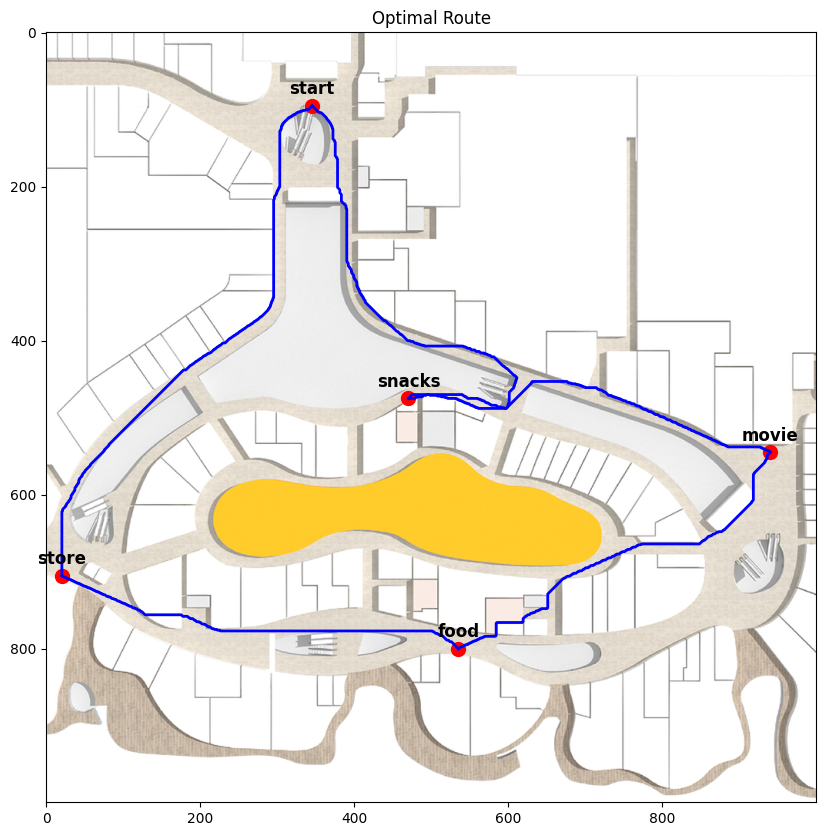

In [42]:
plot_path_on_map(floor_plan, path_dict, greedy_route, locations)

## Task 3